# chapter 10

In [1]:
import numpy as np
import random
import pandas as pd
import scipy.stats
from scipy.special import logsumexp
from sklearn.model_selection import train_test_split
import itertools

import matplotlib as plt
import matplotlib.pyplot as plt
plt.rcdefaults()
import matplotlib as mpl
mpl.rc("figure", facecolor="white")
plt.rc('axes', axisbelow=True)
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import pymc3 as pm
import arviz as az

import altair as alt
from vega_datasets import data as data_alt

# EZ

In [2]:
np.log(0.35/(1-0.35))

-0.6190392084062235

In [3]:
np.exp(3.2) / (1+ np.exp(3.2))

0.9608342772032357

In [4]:
np.exp(1.7)

5.4739473917272

# hard

## H1 and H2

In [5]:
data = pd.read_csv('chimps.txt', sep=';')
data['obs'] = data.index.to_list()

# dums vars
dums = pd.get_dummies(data['actor'])
dums.columns = [f'actor_{i}' for i in list(dums)]
dums['obs'] = dums.index.to_list()

data = data.merge(dums)
data.head(2)

,actor,recipient,condition,block,trial,prosoc_left,chose_prosoc,pulled_left,obs,actor_1,actor_2,actor_3,actor_4,actor_5,actor_6,actor_7
0,1,NaN,0,1,2,0,1,0,0,1,0,0,0,0,0,0
1,1,NaN,0,1,4,0,0,1,1,1,0,0,0,0,0,0


In [6]:
with pm.Model() as model_1:
    
    # priors
    alpha_1 = pm.Normal('alpha_1', 0, 10)
    alpha_2 = pm.Normal('alpha_2', 0, 10)
    alpha_3 = pm.Normal('alpha_3', 0, 10)
    alpha_4 = pm.Normal('alpha_4', 0, 10)
    alpha_5 = pm.Normal('alpha_5', 0, 10)
    alpha_6 = pm.Normal('alpha_6', 0, 10)
    alpha_7 = pm.Normal('alpha_7', 0, 10)
    
    bP = pm.Normal('bP', 0, 10)
    bPC = pm.Normal('bPC', 0, 10)
    
    # deterministic
    prob = pm.math.sigmoid(alpha_1*data['actor_1'] + 
                           alpha_2*data['actor_2'] + 
                           alpha_3*data['actor_3'] + 
                           alpha_4*data['actor_4'] + 
                           alpha_5*data['actor_5'] + 
                           alpha_6*data['actor_6'] + 
                           alpha_7*data['actor_7'] + 
                           bP*data['condition'] + bPC*data['condition']*data['prosoc_left'])
    
    # likelihood
    l_hood = pm.Binomial('l_hood', n=1, p=prob, observed=data['pulled_left'])
    
    # go time
    trace_1 = pm.sample(1000)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [bPC, bP, alpha_7, alpha_6, alpha_5, alpha_4, alpha_3, alpha_2, alpha_1]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 26 seconds.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.


In [7]:
pm.summary(trace_1)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha_1,-0.206,0.258,-0.699,0.245,0.006,0.005,1628.0,1124.0,1627.0,1116.0,1.0
alpha_2,11.186,4.905,4.070,20.399,0.179,0.127,752.0,749.0,816.0,991.0,1.0
alpha_3,-0.519,0.283,-1.045,0.011,0.007,0.005,1497.0,1339.0,1495.0,1027.0,1.0
alpha_4,-0.506,0.277,-1.040,-0.002,0.007,0.005,1437.0,1362.0,1440.0,1232.0,1.0
alpha_5,-0.202,0.276,-0.750,0.272,0.007,0.005,1504.0,1343.0,1520.0,1105.0,1.0
alpha_6,0.741,0.276,0.233,1.243,0.007,0.005,1669.0,1603.0,1675.0,1458.0,1.0
alpha_7,2.330,0.440,1.560,3.150,0.013,0.010,1161.0,1039.0,1244.0,988.0,1.0
bP,-0.752,0.264,-1.259,-0.270,0.009,0.006,956.0,921.0,959.0,985.0,1.0
bPC,0.917,0.312,0.254,1.440,0.009,0.007,1177.0,1112.0,1174.0,1069.0,1.0


In [8]:
# now compare to the simple model, with only one alpha
with pm.Model() as model_2:
    
    # priors
    alpha = pm.Normal('alpha', 0, 10)
    bP = pm.Normal('bP', 0, 10)
    bPC = pm.Normal('bPC', 0, 10)
    
    # deterministic
    prob = pm.math.sigmoid(alpha + bP*data['condition'] + bPC*data['condition']*data['prosoc_left'])
    
    # likelihood
    l_hood = pm.Binomial('l_hood', n=1, p=prob, observed=data['pulled_left'])
    
    # go time
    trace_2 = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [bPC, bP, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 16 seconds.


In [9]:
model_1.name = 'model_1'
model_2.name = 'model_2'

In [10]:
waic_df = pm.compare({model_1.name:trace_1,
            model_2.name:trace_2}, ic='WAIC')

waic_df

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
model_1,0,-266.424,8.54563,0,1,10.0652,0,False,log
model_2,1,-342.403,3.2479,75.9787,1.33237e-19,4.43699,9.61186,False,log


In [11]:
# MODEL 1 is WAY WAY BETTER

## H3

In [12]:
eagles = pd.read_csv('eagles.csv', sep=',')
eagles

,y,n,P,A,V
0,17,24,L,A,L
1,29,29,L,A,S
2,17,27,L,I,L
3,20,20,L,I,S
4,1,12,S,A,L
5,15,16,S,A,S
6,0,28,S,I,L
7,1,4,S,I,S


In [13]:
# do some encoding
eagles['P'] = eagles['P'].apply(lambda x: 1 if x == 'L' else 0)
eagles['A'] = eagles['A'].apply(lambda x: 1 if x == 'A' else 0)
eagles['V'] = eagles['V'].apply(lambda x: 1 if x == 'L' else 0)
eagles

,y,n,P,A,V
0,17,24,1,1,1
1,29,29,1,1,0
2,17,27,1,0,1
3,20,20,1,0,0
4,1,12,0,1,1
5,15,16,0,1,0
6,0,28,0,0,1
7,1,4,0,0,0


In [14]:
# fit an EZ model
# now compare to the simple model, with only one alpha
with pm.Model() as model_3:
    
    # priors
    alpha = pm.Normal('alpha', 0, 10)
    bP = pm.Normal('bP', 0, 5)
    bV = pm.Normal('bV', 0, 5)
    bA = pm.Normal('bA', 0, 5)

    # deterministic
    prob = pm.math.sigmoid(alpha + bP*eagles['P'] + bV*eagles['V']+ bA*eagles['A'])
    
    # likelihood
    l_hood = pm.Binomial('l_hood', n=eagles['n'], p=prob, observed=eagles['y'])
    
    # go time
    trace_3 = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [bA, bV, bP, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 21 seconds.


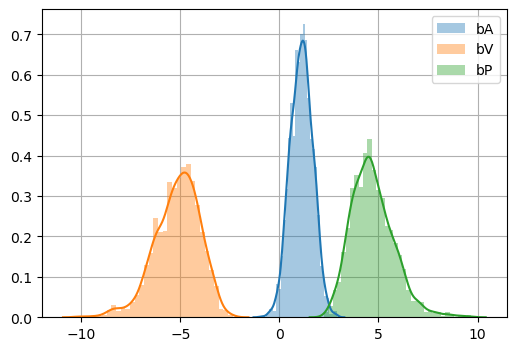

In [20]:
# is the quadratic approx OK?
plt.figure(figsize=(6,4))

for i in ['bA', 'bV', 'bP']:
    sns.distplot(trace_3[i], label=i)

plt.legend()
plt.grid()
plt.show() 

In [21]:
# i'd say they look reasonably normally distributed to me!

## B

In [22]:
# shiz makes sense too, large pirates are successful w/ small victims

In [23]:
# plot posterior predictions
pm.summary(trace_3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,0.695,0.728,-0.643,2.019,0.023,0.017,967.0,905.0,976.0,997.0,1.0
bP,4.710,1.077,2.735,6.557,0.040,0.031,718.0,620.0,820.0,587.0,1.0
bV,-5.155,1.140,-7.182,-3.131,0.044,0.033,663.0,603.0,737.0,598.0,1.0
bA,1.117,0.560,0.093,2.126,0.016,0.012,1173.0,1136.0,1172.0,1246.0,1.0


In [27]:
# plot proportions; get bounds too
map_estimate = pm.find_MAP(model=model_3)
map_estimate

{'alpha': array(0.59154318),
 'bP': array(4.24182384),
 'bV': array(-4.59260843),
 'bA': array(1.08141052)}

In [53]:
log_odds = map_estimate['alpha']+ map_estimate['bP']*eagles['P'] + map_estimate['bV']*eagles['V'] + map_estimate['bA']*eagles['A']
probs = map(lambda x: np.exp(x) / (1 + np.exp(x)), log_odds)
eagles['predicted_prob'] = list(probs)
eagles['calc_prob'] = eagles['y'] / eagles['n']
eagles

,y,n,P,A,V,predicted_prob,calc_prob
0,17,24,1,1,1,0.789542,0.708333
1,29,29,1,1,0,0.997308,1.000000
2,17,27,1,0,1,0.559901,0.629630
3,20,20,1,0,0,0.992103,1.000000
4,1,12,0,1,1,0.051190,0.083333
5,15,16,0,1,0,0.841969,0.937500
6,0,28,0,0,1,0.017967,0.000000
7,1,4,0,0,0,0.643719,0.250000


In [87]:
# get interval; need to use the samples for this
# get the CI
ci = 0.89
lower = []; upper = []
for P, A, V in zip(eagles['P'], eagles['A'], eagles['V']):
    sample_ = np.array(trace_3['alpha'] + trace_3['bP']*P + trace_3['bV']*V + trace_3['bA']*A)
    probs_ = np.exp(sample_) / (1 + np.exp(sample_))
    lower_, upper_ = pm.stats.hpd(probs_, alpha=ci)
    lower.append(lower_)
    upper.append(upper_)
    
eagles['upper'] = upper
eagles['lower'] = lower

In [88]:
eagles

,y,n,P,A,V,predicted_prob,calc_prob,upper,lower
0,17,24,1,1,1,0.789542,0.708333,0.924200,0.653529
1,29,29,1,1,0,0.997308,1.000000,0.999993,0.992196
2,17,27,1,0,1,0.559901,0.629630,0.724935,0.392939
3,20,20,1,0,0,0.992103,1.000000,0.999969,0.977532
4,1,12,0,1,1,0.051190,0.083333,0.131718,0.000192
5,15,16,0,1,0,0.841969,0.937500,0.970110,0.693579
6,0,28,0,0,1,0.017967,0.000000,0.049283,0.000080
7,1,4,0,0,0,0.643719,0.250000,0.907820,0.381555


In [ ]:
# to get counts, multiple by n

## C

In [92]:
# add interaction between age and size for pirate
# fit an EZ model
# now compare to the simple model, with only one alpha
with pm.Model() as model_4:
    
    # priors
    alpha = pm.Normal('alpha', 0, 10)
    bP = pm.Normal('bP', 0, 5)
    bV = pm.Normal('bV', 0, 5)
    bA = pm.Normal('bA', 0, 5)
    bAP = pm.Normal('bAP', 0, 5)

    # deterministic
    prob = pm.math.sigmoid(alpha + bP*eagles['P'] + bV*eagles['V']+ bA*eagles['A'] + bAP*eagles['A']*eagles['P'])
    
    # likelihood
    l_hood = pm.Binomial('l_hood', n=eagles['n'], p=prob, observed=eagles['y'])
    
    # go time
    trace_4 = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [bAP, bA, bV, bP, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 26 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [95]:
model_3.name = 'model_3'
model_4.name = 'model_4'

waic_df = pm.compare({model_3.name:trace_3,
            model_4.name:trace_4}, ic='WAIC')

waic_df

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
model_4,0,-10.2241,1.97545,0,0.988735,3.79769,0,True,log
model_3,1,-15.7361,5.57253,5.51203,0.0112647,2.70854,1.80281,True,log


In [96]:
# INTERACTION MAKES IT WAY MORE BETTER

# H4

In [102]:
# poisson regression to salamander data
sals = pd.read_csv('sals.txt', sep=';')
sals.head()

,SITE,SALAMAN,PCTCOVER,FORESTAGE
0,1,13,85,316
1,2,11,86,88
2,3,11,90,548
3,4,9,88,64
4,5,8,89,43


In [103]:
# scale the data
sals['PCTCOVER'] = (sals['PCTCOVER'] - sals['PCTCOVER'].mean()) / sals['PCTCOVER'].std()
sals['FORESTAGE'] = (sals['FORESTAGE'] - sals['FORESTAGE'].mean()) / sals['FORESTAGE'].std()


In [106]:
# now fit poission regression
with pm.Model() as model_5:
    
    # priors
    alpha = pm.Normal('alpha', 0, 10)
    bP = pm.Normal('bP', 0, 5)
    bF = pm.Normal('bF', 0, 5)

    # deterministic; note the diferent link function
    lambda_ = pm.math.exp(alpha + bP*sals['PCTCOVER'] + bF*sals['FORESTAGE'])
    
    # likelihood
    l_hood = pm.Poisson('l_hood', mu=lambda_, observed=sals['SALAMAN'])
    
    # go time
    trace_4 = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [bF, bP, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 26 seconds.


In [107]:
pm.summary(trace_4)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,0.398,0.166,0.093,0.713,0.005,0.004,929.0,929.0,967.0,871.0,1.0
bP,1.190,0.213,0.805,1.598,0.007,0.005,832.0,811.0,837.0,979.0,1.0
bF,-0.005,0.100,-0.176,0.194,0.003,0.002,1178.0,894.0,1179.0,1067.0,1.0
